In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm

from numpy import random
import datetime
from random import randint

import matplotlib.pyplot as plt
import seaborn as sns

from fitter import Fitter, get_common_distributions, get_distributions

In [2]:
# Change according to file path of the dataset
file_path = r'C:\Users\General\Desktop\CAPSTONE\Datasets\timeseries1.csv'

a = pd.read_csv(file_path)
a

,date,value
0,2022-01-01,-0.601368
1,2022-01-02,0.319782
2,2022-01-03,-1.592994
3,2022-01-04,0.440475
4,2022-01-05,-0.019638
...,...,...
295,2022-10-23,-3.760809
296,2022-10-24,-3.525656
297,2022-10-25,-0.737416
298,2022-10-26,-2.551858


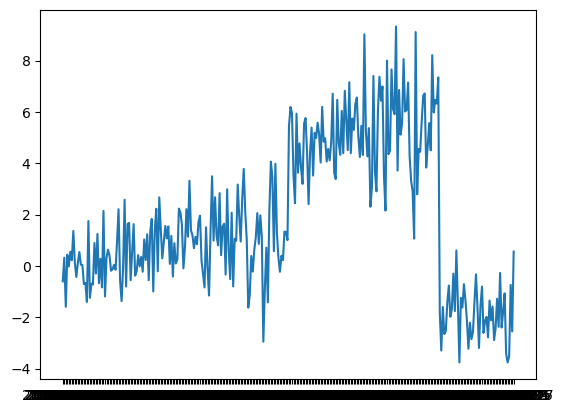

In [3]:
# Initial plot of the data
plt.plot(a['date'], a['value'])
plt.show()

In [4]:
y = a['value']

In [5]:
type(y)

pandas.core.series.Series

In [6]:
class CusumDetector:
    
    def __init__(self, t_warmup = 30, p_limit= 0.01):
        self._t_warmup = t_warmup
        self._p_limit = p_limit
        self._reset()
        
    def predict_next(self, y):
        self._update_data(y)
        
        if self.current_t == self._t_warmup:
            self._init_params()
            
        if self.current_t >= self._t_warmup:
            prob, is_changepoint = self._check_for_changepoint()
            
            if is_changepoint:
                self._reset()
                
            return (1-prob), is_changepoint
        
        else:
            return 0, False
        
    def _reset(self):
        self.current_t = 0
        self.current_obs = []
        self.current_mean = None
        self.current_std = None
        
    def _update_data(self, y):
        self.current_t += 1
        self.current_obs.append(y)

    def _init_params(self):
        self.obs = pd.Series(self.current_obs)
        f = Fitter(self.obs, distributions=["norm"])
        f.fit()
        self.current_mean = f.fitted_param["norm"][0]
        self.current_std = f.fitted_param["norm"][1]
        
    def _check_for_changepoint(self):
        standardized_sum = (np.sum(self.current_obs) - (self.current_t * self.current_mean)) / (self.current_std * self.current_t**0.5)
        prob = float(self._get_prob(standardized_sum))
        
        return prob, prob < self._p_limit
    
    def _get_prob(self, y):
        p = norm.cdf(np.abs(y))  # 0.5 * (1 + np.math.erf(np.abs(y) / np.sqrt(2)))
        prob = 2 * (1 - p)
        
        return prob

2024-03-04 12:30:58.928 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=28.125053)
2024-03-04 12:30:58.967 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=19.437523)
2024-03-04 12:30:59.022 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=15.129149)
2024-03-04 12:30:59.059 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=3.223378)
2024-03-04 12:30:59.103 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=22.040829)


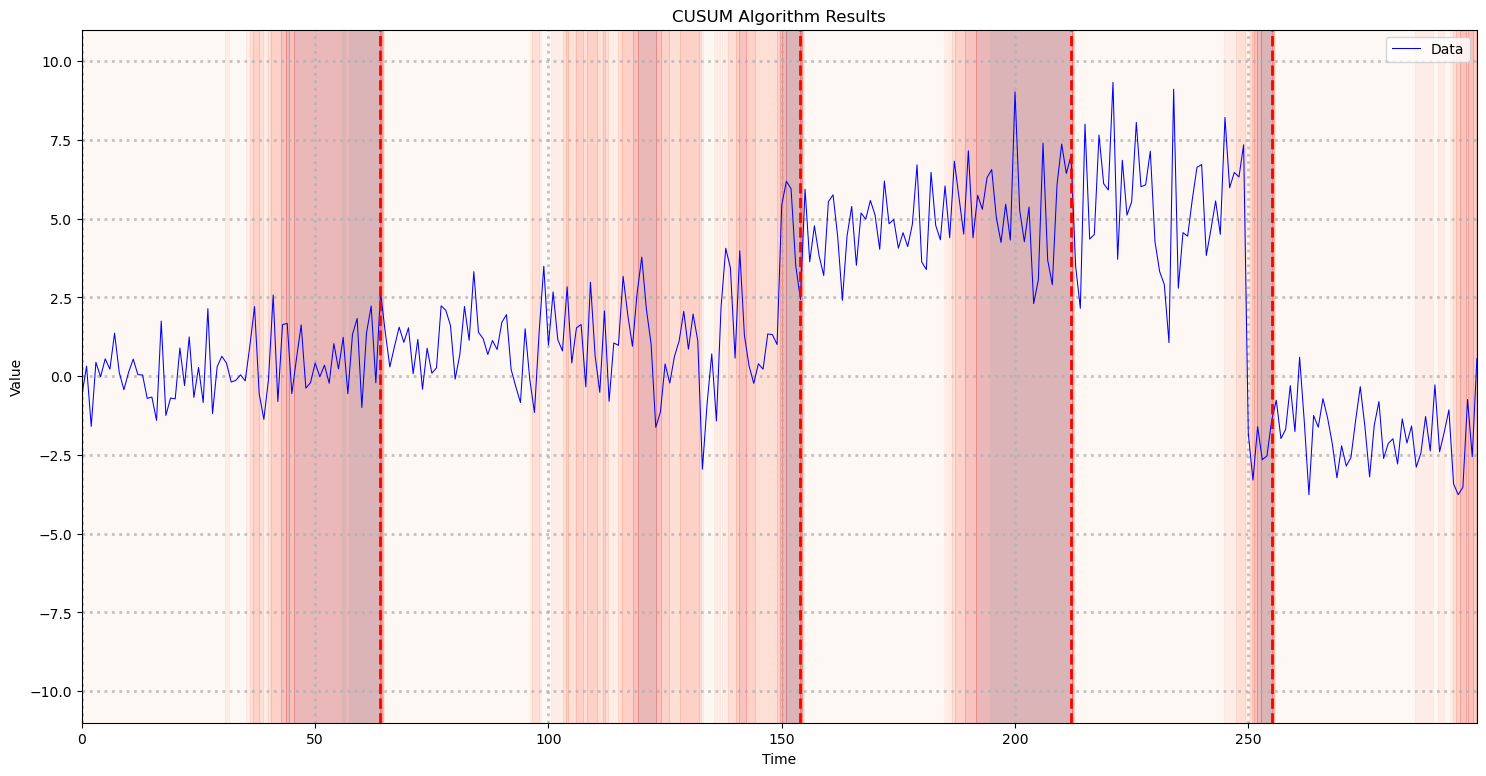

In [8]:
# Initialize CUSUM detector
test = CusumDetector()
outs = [test.predict_next(y[i]) for i in range(len(y))]

# Extract change points and probabilities
cps = np.where(list(map(lambda x: x[1], outs)))[0]
probs = np.array(list(map(lambda x: x[0], outs)))

# Plot results
X, Y = np.meshgrid(np.arange(len(y)), np.linspace(-11, 11))
Z = probs[X]

plt.figure(figsize=(18, 9))
plt.contourf(X, Y, Z, alpha=0.3, cmap="Reds")
plt.plot(np.arange(len(y)), y, lw=0.75, label="Data", color="blue")

# Plot detected changepoints
[plt.axvline(cp, color="red", linestyle="dashed", lw=2) for cp in cps]

plt.grid(alpha=0.75, linestyle="dotted", lw=2)
plt.legend()
plt.title("CUSUM Algorithm Results")
plt.xlabel("Time")
plt.ylabel("Value")
plt.show()